<a href="https://colab.research.google.com/github/asia281/dnn2022/blob/main/Asia_of_hw1_checkpoints_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Checkpointing

Your task is to implement checkpointing for a MLP using NumPy.

You are free to use the implementation of a MLP and the backpropagation algorithm that you have developed during lab sessions.

The key takeaway from this task is that with checkpointing we can trade off the computational resources needed to compute the forward pass of the network for the memory requirement needed to perform a backward pass in the network, which is often a major bottleneck when training large networks. In plain english, we can slightly increase the time required for training our network to save some of our GPU's precious memory.

## What is checkpointing?

The aim of checkpointing is to save every $n$-th layer's (e.g. every 2-nd layer's) forward result (instead of saving every layer's forward result as in plain backpropagation) and use these checkpoints for recomputing the forward pass of the network upon doing a backward pass. Checkpoint layers are kept in memory after the forward pass, while the remaining activations are recomputed at most once. After being recomputed, the non-checkpoint layers are kept in memory until they are no longer required.

# What should be done

1. Take the implementation a MLP trained with backpropagation. Analyze the algorithm with respect to the memory that is used by the algorithm with respect to the number of hidden layers.

2. Implement a class NetworkWithCheckpointing that inherits from the Network class defined during lab sessions by:
    a) implementing a method `forward_between_checkpoints` that will recompute the forward pass of the network using one of the checkpointed layers
    b) override the method `backprop` to use only checkpointed layers and otherwise compute the activations using `forward_between_checkpoints` method and keep it in memory until no longer needed.

3. Train your network with checkpoinintg on MNIST. Compare running times and memory usage with respect to the network without checkpointing.


# Implement Checkpointing for a MLP

In [ ]:
import random
import numpy as np
from torchvision import datasets, transforms

In [ ]:
!wget -O mnist.npz https://s3.amazonaws.com/img-datasets/mnist.npz

--2022-11-19 19:24:16--  https://s3.amazonaws.com/img-datasets/mnist.npz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.112.229, 52.217.38.78, 52.217.132.120, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.112.229|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11490434 (11M) [application/octet-stream]
Saving to: ‘mnist.npz’

mnist.npz           100%[===================>]  10.96M  5.98MB/s    in 1.8s    

2022-11-19 19:24:19 (5.98 MB/s) - ‘mnist.npz’ saved [11490434/11490434]



In [ ]:
# Let's read the mnist dataset
def load_mnist(path='mnist.npz'):
    with np.load(path) as f:
        x_train, _y_train = f['x_train'], f['y_train']
        x_test, _y_test = f['x_test'], f['y_test']

    x_train = x_train.reshape(-1, 28 * 28) / 255.
    x_test = x_test.reshape(-1, 28 * 28) / 255.

    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1

    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    return (x_train, y_train), (x_test, y_test)

# And assign the variables
(x_train, y_train), (x_test, y_test) = load_mnist()

In [ ]:
# Declaration of sigmoid and softmax functions
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def softmax(z):
    exps = np.exp(z - np.max(z))
    sum = np.sum(exps, axis=0)
    res = exps / sum
    return res

In [ ]:
import matplotlib.pyplot as plt

# Function to plot 
def plot_learning_curve(test_accs):
    xs = range(1, len(test_accs) + 1)
    plt.clf()
    plt.plot(xs, test_accs, label='test accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Number of epochs')
    plt.grid()
    plt.legend()
    plt.show()

In my implementation of `Network`, I'm using SDG momentum, L2 regularization, and softmax as an activation for the last layer. In all the experiments, I'm using `%time` to measure the time. I'm running a network with almost all the same hyperparameters, changing only the number of layers and how often to create checkpoints.

In [ ]:
class Network(object):
    def __init__(self, sizes, l2=0.0, momentum=0.0):
        # initialize biases and weights with random normal distr.
        # weights are indexed by target node first
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.l2 = l2
        self.momentum = momentum
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]
        self.weights_momentum = [np.zeros_like(x) for x in self.weights]
        self.biases_momentum = [np.zeros_like(x) for x in self.biases]
    
    def activation(self, z, l):
        if l == (self.num_layers - 1):
            return softmax(z)

        return sigmoid(z)
    
    def feedforward(self, a):
        # Run the network on a batch
        a = a.T
        for l, b, w in zip(range(1, self.num_layers), self.biases, self.weights):
          a = self.activation(np.matmul(w, a)+b, l)
        return a
    
    def update_mini_batch(self, mini_batch, eta):
        nabla_b, nabla_w = self.backprop(mini_batch[0].T,mini_batch[1].T)
        
        self.weights_momentum = [(self.momentum*wm)-(eta/len(mini_batch[0]))*nw 
                                 for wm, w, nw in zip(self.weights_momentum, self.weights, nabla_w)]
        self.biases_momentum = [(self.momentum*bm)-(eta/len(mini_batch[0]))*nb 
                                for bm, b, nb in zip(self.biases_momentum, self.biases, nabla_b)]
                            
        self.weights = [w+wm for w, wm in zip(self.weights, self.weights_momentum)]
        self.biases = [b+bm for b, bm in zip(self.biases, self.biases_momentum)]
        
    def backprop(self, x, y):
        g = x
        gs = [g] # list to store all the gs, layer by layer
        fs = [] # list to store all the fs, layer by layer
        for l, b, w in zip(range(1, self.num_layers), self.biases, self.weights):
            f = np.dot(w, g)+b
            fs.append(f)
            g = self.activation(f, l)
            gs.append(g)
            
        dLdf = self.cost_derivative(gs[-1], y)
        dLdfs = []
        for l,w,g in reversed(list(zip(range(1, self.num_layers), self.weights, gs[1:]))):
            if l < (self.num_layers - 1):
                dLdf = np.multiply(dLdg, np.multiply(g,1-g))
            dLdfs.append(dLdf)
            dLdg = np.matmul(w.T, dLdf)
        
        dLdWs = [np.matmul(dLdf,g.T) + (self.l2 * w) for dLdf, g, w in zip(reversed(dLdfs), gs[:-1], self.weights)] 
        dLdBs = [np.sum(dLdf,axis=1).reshape(dLdf.shape[0],1) for dLdf in reversed(dLdfs)] 

        return (dLdBs, dLdWs)

    def evaluate(self, test_data):
        # Count the number of correct answers for test_data
        pred = np.argmax(self.feedforward(test_data[0]),axis=0)
        corr = np.argmax(test_data[1],axis=1).T
        return np.mean(pred==corr)
    
    def cost_derivative(self, output_activations, y):
        return (output_activations-y) 
    
    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):
        x_train, y_train = training_data
        if test_data:
            x_test, y_test = test_data
        accs = []
        for j in range(epochs):
            for i in range(x_train.shape[0] // mini_batch_size):
                x_mini_batch = x_train[(mini_batch_size*i):(mini_batch_size*(i+1))]
                y_mini_batch = y_train[(mini_batch_size*i):(mini_batch_size*(i+1))]
                self.update_mini_batch((x_mini_batch, y_mini_batch), eta)
            if test_data:
                acc = self.evaluate((x_test, y_test))
                accs.append(acc)
                print("Epoch: {0}, Accuracy: {1}".format(j, acc))
            else:
                print("Epoch: {0}".format(j))
        plot_learning_curve(accs)

Epoch: 0, Accuracy: 0.8947
Epoch: 1, Accuracy: 0.9222
Epoch: 2, Accuracy: 0.9362
Epoch: 3, Accuracy: 0.9322
Epoch: 4, Accuracy: 0.9398
Epoch: 5, Accuracy: 0.9443
Epoch: 6, Accuracy: 0.9469
Epoch: 7, Accuracy: 0.9457
Epoch: 8, Accuracy: 0.9472
Epoch: 9, Accuracy: 0.945
Epoch: 10, Accuracy: 0.9509
Epoch: 11, Accuracy: 0.9516
Epoch: 12, Accuracy: 0.9503
Epoch: 13, Accuracy: 0.9512
Epoch: 14, Accuracy: 0.9514
Epoch: 15, Accuracy: 0.9503
Epoch: 16, Accuracy: 0.9559
Epoch: 17, Accuracy: 0.952
Epoch: 18, Accuracy: 0.9519
Epoch: 19, Accuracy: 0.9518


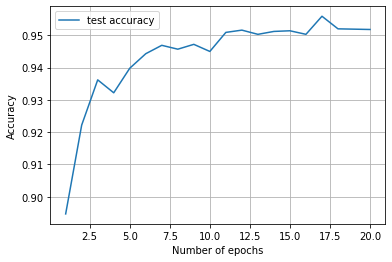

CPU times: user 32.5 s, sys: 13.1 s, total: 45.6 s
Wall time: 23.6 s


In [ ]:
network = Network([784,30,10], l2=0.001, momentum=0.7)
%time network.SGD((x_train, y_train), epochs=20, mini_batch_size=100, eta=3., test_data=(x_test, y_test))

NetworkWithCheckpointing stores feedforward results only after checkpoint_every_nth_layer layer. The only function we changed is backprop which uses the forward_between_checkpoints function.
While forward pass, we save only some variables. To restore them for unsaved indices, we use the get function, which recursively computes variables between two checkpoints.
After using gs for idx % checkpoint_every_nth_layer != 0, we delete them.

In [ ]:
class NetworkWithCheckpointing(Network):
    def __init__(self, sizes, checkpoint_every_nth_layer: int = 0, *args, **kwargs):
        super().__init__(sizes, *args, **kwargs)
        self.checkpoint_freq = checkpoint_every_nth_layer
        self.layers_nr = len(sizes)

    # Function to get an element from the dict that is computed recursively
    def get(self, d: dict, idx: int):
      if idx in d:
        return d[idx]
      mul = np.matmul(self.weights[idx - 1], self.get(d, idx - 1))
      d[idx] = sigmoid(mul + self.biases[idx - 1])
      return d[idx]

    def delete(self, d: dict, idx: int):
      if idx % self.checkpoint_freq != 0 and idx in d:
        del d[idx]

    def forward_between_checkpoints(self, a, start, end):
      is_last = (end == self.layers_nr - 1)
      if is_last:
        end -= 1
      for b, w in zip(self.biases[start:end], self.weights[start:end]):
        a = sigmoid(np.dot(w, a) + b)   
      if is_last:
        return softmax(np.matmul(self.weights[-1], a) + self.biases[-1])

      return a

    def backprop(self, x, y):
      gs = {}
      g = x
      gs[0] = g

      for i in range(0, self.layers_nr - 1, self.checkpoint_freq):
        end = min(self.layers_nr - 1, i + self.checkpoint_freq)
        g = self.forward_between_checkpoints(g, i, end)
        gs[end] = g
      # backward pass <- both steps at once
      idx = self.layers_nr - 1
      dLdf = self.cost_derivative(gs[idx], y)
      dLdfs = []
      dLdWs = []
      for idx, w in reversed(list(zip(range(1, self.num_layers), self.weights))):
        if idx < (self.num_layers - 1):
          #Compute gs[idx]
          g = self.get(gs, idx)
          # Delete not necessary computed gs[idx]
          self.delete(gs, idx)
          dLdf = np.multiply(dLdg,np.multiply(g,1-g))

        dLdfs.append(dLdf)
        dLdg = np.matmul(w.T, dLdf)

      for idx, w in enumerate(reversed(dLdfs)):
        dLdWs.append(np.matmul(w, self.get(gs, idx).T))
        # Delete computed gs[idx]
        if idx > 0:
          del gs[idx-1]
      
      # Apply L2 regularization
      dLdWs = dLdWs + [self.l2 * w for w in self.weights]
      dLdBs = [np.sum(dLdf,axis=1).reshape(dLdf.shape[0],1) for dLdf in reversed(dLdfs)] 
      return (dLdBs, dLdWs)


Epoch: 0, Accuracy: 0.8927
Epoch: 1, Accuracy: 0.9188
Epoch: 2, Accuracy: 0.9286
Epoch: 3, Accuracy: 0.934
Epoch: 4, Accuracy: 0.9381
Epoch: 5, Accuracy: 0.9406
Epoch: 6, Accuracy: 0.943
Epoch: 7, Accuracy: 0.9441
Epoch: 8, Accuracy: 0.9459
Epoch: 9, Accuracy: 0.9466
Epoch: 10, Accuracy: 0.9459
Epoch: 11, Accuracy: 0.9458
Epoch: 12, Accuracy: 0.9455
Epoch: 13, Accuracy: 0.9456
Epoch: 14, Accuracy: 0.9457
Epoch: 15, Accuracy: 0.9475
Epoch: 16, Accuracy: 0.9477
Epoch: 17, Accuracy: 0.9477
Epoch: 18, Accuracy: 0.9484
Epoch: 19, Accuracy: 0.9485


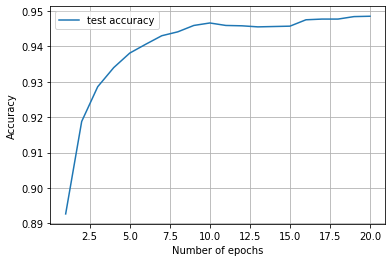

CPU times: user 50 s, sys: 17.1 s, total: 1min 7s
Wall time: 34.6 s


In [ ]:
net_check = NetworkWithCheckpointing([784,30,10], 2)
%time net_check.SGD((x_train, y_train), epochs=20, mini_batch_size=100, eta=3., test_data=(x_test, y_test))

Epoch: 0, Accuracy: 0.9115
Epoch: 1, Accuracy: 0.9262
Epoch: 2, Accuracy: 0.9342
Epoch: 3, Accuracy: 0.943
Epoch: 4, Accuracy: 0.9421
Epoch: 5, Accuracy: 0.9504
Epoch: 6, Accuracy: 0.9507
Epoch: 7, Accuracy: 0.9503
Epoch: 8, Accuracy: 0.9519
Epoch: 9, Accuracy: 0.9515
Epoch: 10, Accuracy: 0.952
Epoch: 11, Accuracy: 0.9527
Epoch: 12, Accuracy: 0.9564
Epoch: 13, Accuracy: 0.9556
Epoch: 14, Accuracy: 0.9573
Epoch: 15, Accuracy: 0.9568
Epoch: 16, Accuracy: 0.9585
Epoch: 17, Accuracy: 0.9559
Epoch: 18, Accuracy: 0.9576
Epoch: 19, Accuracy: 0.9552


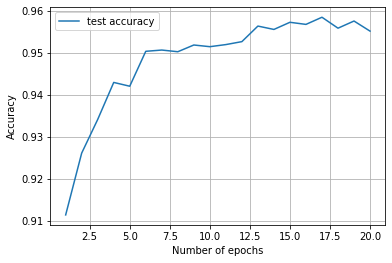

CPU times: user 33.3 s, sys: 12.3 s, total: 45.6 s
Wall time: 23.6 s
Epoch: 0, Accuracy: 0.9056
Epoch: 1, Accuracy: 0.9277
Epoch: 2, Accuracy: 0.9359
Epoch: 3, Accuracy: 0.9305
Epoch: 4, Accuracy: 0.9417
Epoch: 5, Accuracy: 0.9459
Epoch: 6, Accuracy: 0.9441
Epoch: 7, Accuracy: 0.9473
Epoch: 8, Accuracy: 0.9461
Epoch: 9, Accuracy: 0.9476
Epoch: 10, Accuracy: 0.949
Epoch: 11, Accuracy: 0.9494
Epoch: 12, Accuracy: 0.9485
Epoch: 13, Accuracy: 0.9494
Epoch: 14, Accuracy: 0.9483
Epoch: 15, Accuracy: 0.9493
Epoch: 16, Accuracy: 0.9508
Epoch: 17, Accuracy: 0.9506
Epoch: 18, Accuracy: 0.9497
Epoch: 19, Accuracy: 0.9484


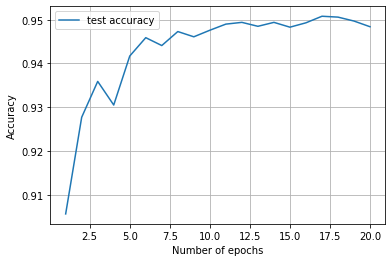

CPU times: user 32.4 s, sys: 13.1 s, total: 45.5 s
Wall time: 23.5 s


In [ ]:
network = Network([784,30,10], l2=0.001, momentum=0.6)
%time network.SGD((x_train, y_train), epochs=20, mini_batch_size=100, eta=3., test_data=(x_test, y_test))

network_check = NetworkWithCheckpointing([784,30,10], 1, l2=0.001, momentum=0.6)
%time network_check.SGD((x_train, y_train), epochs=20, mini_batch_size=100, eta=3., test_data=(x_test, y_test))

Epoch: 0, Accuracy: 0.8916
Epoch: 1, Accuracy: 0.9161
Epoch: 2, Accuracy: 0.9171
Epoch: 3, Accuracy: 0.933
Epoch: 4, Accuracy: 0.9334
Epoch: 5, Accuracy: 0.9388
Epoch: 6, Accuracy: 0.9396
Epoch: 7, Accuracy: 0.9409
Epoch: 8, Accuracy: 0.9359
Epoch: 9, Accuracy: 0.9434
Epoch: 10, Accuracy: 0.9477
Epoch: 11, Accuracy: 0.9508
Epoch: 12, Accuracy: 0.9476
Epoch: 13, Accuracy: 0.9542
Epoch: 14, Accuracy: 0.948
Epoch: 15, Accuracy: 0.9435
Epoch: 16, Accuracy: 0.9368
Epoch: 17, Accuracy: 0.9444
Epoch: 18, Accuracy: 0.9488
Epoch: 19, Accuracy: 0.9516


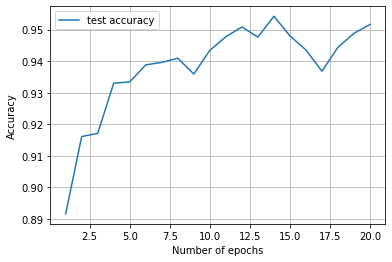

CPU times: user 38.3 s, sys: 13.9 s, total: 52.2 s
Wall time: 27.1 s
Epoch: 0, Accuracy: 0.8794
Epoch: 1, Accuracy: 0.8971
Epoch: 2, Accuracy: 0.923
Epoch: 3, Accuracy: 0.9263
Epoch: 4, Accuracy: 0.9321
Epoch: 5, Accuracy: 0.933
Epoch: 6, Accuracy: 0.9267
Epoch: 7, Accuracy: 0.9401
Epoch: 8, Accuracy: 0.9344
Epoch: 9, Accuracy: 0.9394
Epoch: 10, Accuracy: 0.9441
Epoch: 11, Accuracy: 0.9434
Epoch: 12, Accuracy: 0.9442
Epoch: 13, Accuracy: 0.9413
Epoch: 14, Accuracy: 0.9434
Epoch: 15, Accuracy: 0.9423
Epoch: 16, Accuracy: 0.948
Epoch: 17, Accuracy: 0.9445
Epoch: 18, Accuracy: 0.95
Epoch: 19, Accuracy: 0.9452


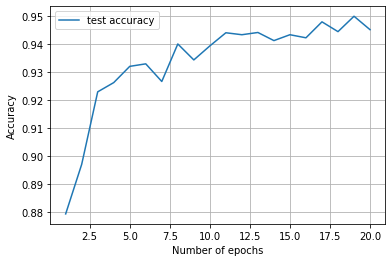

CPU times: user 53.8 s, sys: 21.5 s, total: 1min 15s
Wall time: 38.7 s


In [ ]:
network = Network([784,30,30,10], l2=0.001, momentum=0.6)
%time network.SGD((x_train, y_train), epochs=20, mini_batch_size=100, eta=3., test_data=(x_test, y_test))

network_check = NetworkWithCheckpointing([784,30,30,10], 2, l2=0.001, momentum=0.6)
%time network_check.SGD((x_train, y_train), epochs=20, mini_batch_size=100, eta=3., test_data=(x_test, y_test))

Epoch: 0, Accuracy: 0.8663
Epoch: 1, Accuracy: 0.9063
Epoch: 2, Accuracy: 0.9231
Epoch: 3, Accuracy: 0.9268
Epoch: 4, Accuracy: 0.9442
Epoch: 5, Accuracy: 0.9359
Epoch: 6, Accuracy: 0.9494
Epoch: 7, Accuracy: 0.9544
Epoch: 8, Accuracy: 0.9592
Epoch: 9, Accuracy: 0.9624
Epoch: 10, Accuracy: 0.9606
Epoch: 11, Accuracy: 0.9602
Epoch: 12, Accuracy: 0.9605
Epoch: 13, Accuracy: 0.9584
Epoch: 14, Accuracy: 0.9609
Epoch: 15, Accuracy: 0.9707
Epoch: 16, Accuracy: 0.9655
Epoch: 17, Accuracy: 0.9653
Epoch: 18, Accuracy: 0.9686
Epoch: 19, Accuracy: 0.97


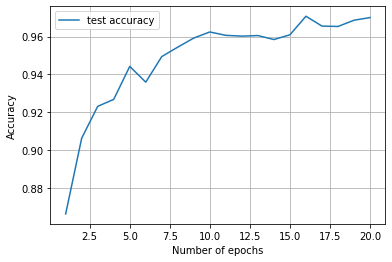

CPU times: user 1min 43s, sys: 38.3 s, total: 2min 21s
Wall time: 1min 15s
Epoch: 0, Accuracy: 0.8614
Epoch: 1, Accuracy: 0.8885
Epoch: 2, Accuracy: 0.9117
Epoch: 3, Accuracy: 0.9125
Epoch: 4, Accuracy: 0.9329
Epoch: 5, Accuracy: 0.9397
Epoch: 6, Accuracy: 0.9384
Epoch: 7, Accuracy: 0.9389
Epoch: 8, Accuracy: 0.9437
Epoch: 9, Accuracy: 0.9476
Epoch: 10, Accuracy: 0.9535
Epoch: 11, Accuracy: 0.9542
Epoch: 12, Accuracy: 0.9549
Epoch: 13, Accuracy: 0.9552
Epoch: 14, Accuracy: 0.9575
Epoch: 15, Accuracy: 0.9592
Epoch: 16, Accuracy: 0.9616
Epoch: 17, Accuracy: 0.9541
Epoch: 18, Accuracy: 0.9576
Epoch: 19, Accuracy: 0.9622


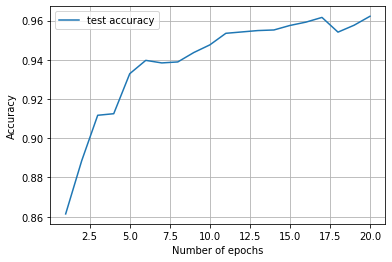

CPU times: user 2min 35s, sys: 1min 10s, total: 3min 45s
Wall time: 1min 55s


In [ ]:
network = Network([784,100,80,50,20,10], l2=0.001, momentum=0.6)
%time network.SGD((x_train, y_train), epochs=20, mini_batch_size=100, eta=3., test_data=(x_test, y_test))

network_check = NetworkWithCheckpointing([784,100,80,50,20,10], 3, l2=0.001, momentum=0.6)
%time network_check.SGD((x_train, y_train), epochs=20, mini_batch_size=100, eta=3., test_data=(x_test, y_test))

During classes, we were told to compute the memory usage only theoretically. 
Let `c := checkpoint_every_nth_layer` and `n := number_of_layers` and `freq := n/c`.

We want to estimate the difference in memory usage between `Network` and `NetworkWithCheckpointing`. As we see, in `NetworkWithCheckpointing`, we store values of forward steps after activation in `gs` which is a dictionary, not an array. In `gs` we are not storing all the values, but one every `c`-th layer. The dict with k elements uses `O(k log k)` memory. Let s = memory usage of results of the forward step for one layer. In `Network`, we use `O(ns)` memory to store these variables. In `NetworkWithCheckpointing`, memory usage is decreased to `O(freq log freq * s)`.

Additionally, while backpropagating, I'm saving the forward activations between two checkpoints. It adds `O(c * s)` to the overall memory usage. 


I wasn't exactly sure if I should save all the forward results between two checkpoints while backprop, and decrease a running time, as I did in experiments, or slightly different method, where I save the variables between two checkpoints. 


If I change get method to the following, and not use the delete method, I will decrease maximum memory usage for saving forward activations to `O(freq log freq * s)`, but also increase the running time.  

In [ ]:
def get(self, d: dict, idx: int):
  if idx in d:
    return d[idx]
  mul = np.matmul(self.weights[idx - 1], self.get(d, idx - 1))
  return sigmoid(mul + self.biases[idx - 1])

While calling the above get method, we need to compute all the dict values from the nearest previous checkopoint, to the idx. 